# Random Fourier features

One central difficulty with Gaussian Processes (GPs) -- and more generally all kernel methods, such as Support Vector Machines (SVMs) -- is their computational cost.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import HTML, set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
css_style = open('../../../_static/custom_style.css', 'r').read()
HTML(f'<style>{css_style}</style>')

<div class="theorem">
    
**Theorem (Bochner's theorem)** A continuous kernel $k(x, y) = k(x - y)$ is positive definite if and only if $k(\delta)$ is the Fourier transform of a non-negative measure.
    
</div>
<br>

Note that this statement slightly abuses the $k$ symbol, using it to denote both the kernel $k(x, y)$ as well as its writing in an explicitly translation-invariant form $k(x - y)$ -- the implied use is clear from context. Bochner's theorem implies that for any translation-invariant kernel $k$, there exists a corresponding non-negative measure such that $k$ is the Fourier transform of it.

$$\begin{align}
k(x - y) = \int p(\omega) e^{-i \omega^\top (x - y)} d\omega = \mathbb{E}_{\omega}\left[\zeta_{\omega}(x)\zeta_{\omega}^*(y)\right].
\end{align}$$

We can therefore get an unbiased estimate of $k(x - y)$ by sampling $\omega \sim p(\omega)$ and computing $\zeta_{\omega}(x)\zeta_{\omega}^*(y)$. Note however, that even though $\mathbb{E}_{\omega}\left[\zeta_{\omega}(x)\zeta_{\omega}^*(y)\right]$ is real, the sampled $\zeta_{\omega}(x)\zeta_{\omega}^*(y)$ will in general be complex. This is an issue if we want to use $\zeta_{\omega}$ to represent real functions. Instead, we can write

$$\begin{align}
\mathbb{E}_{\omega}\left[\zeta_{\omega}(x)\zeta_{\omega}^*(y)\right] &= \text{Re}\left[\mathbb{E}_{\omega}\left[e^{-i \omega^\top (x - y)}\right]\right] \\
                                                                     &= \mathbb{E}_{\omega}\left[\text{Re}\left[e^{-i \omega^\top (x - y)}\right]\right] \\
                                                                     &= \mathbb{E}_{\omega}\left[\cos(\omega^\top (x - y))\right].
\end{align}$$

We would like to manipulate the expression above into an expectation of the form $\mathbb{E}_{\omega}\left[f(x)f(y)\right]$ rather than $\mathbb{E}_{\omega}\left[f(x - y)\right]$, which we can achieve via the following trick. Using the fact that

$$\begin{align}
\mathbb{E}_{\phi}\left[\cos(z + n\phi)\right] = 0,
\end{align}$$

for all $z \in \mathbb{R}, n \in \mathbb{N}^+$, where $\phi \sim \text{Uniform}[0, 2\pi]$, we can re-write the expectation as

$$\begin{align}
\mathbb{E}_{\omega}\left[\zeta_{\omega}(x)\zeta_{\omega}^*(y)\right] &= \mathbb{E}_{\omega, \phi}\left[\cos\left(\omega^\top (x - y)\right) + \cos\left(\omega^\top (x + y\right) + 2b)\right] \\
                                                                     &= \mathbb{E}_{\omega, \phi}\left[2 \cos\left(\omega^\top x + b\right) \cos\left(\omega^\top y + b\right)\right].
\end{align}$$

We can therefore get an unbiased, real valued estimate of $k(x - y)$ by sampling $\omega \sim p(\omega), \phi \sim \text{Uniform}[0, 2\pi]$ and computing

$$\begin{align}
\mathbb{E}_{\omega}\left[\zeta_{\omega}(x)\zeta_{\omega}^*(y)\right] \approx z_{\omega, b}(x) z_{\omega, b}(y), \text{ where } z_{\omega, b}(x) = \sqrt{2} \cos(\omega^\top x + b).
\end{align}$$

In fact, we can go a bit further by drawing $N$ independent pairs of $\omega, b$ and computing the estimate

$$\begin{align}
\mathbb{E}_{\omega}\left[\zeta_{\omega}(x)\zeta_{\omega}^*(y)\right] \approx \frac{1}{N} \sum_{n = 1}^N z_{\omega_n, \phi_n}(x) z_{\omega_n, \phi_n}(y).
\end{align}$$

This is also an unbiased estimate of $k$, however its variance is lower than in the $N = 1$ case, since the variance of the average of the sum of $N$ i.i.d. random variables is lower than the variance of a single one of the variables. We therefore arrive at the following algorithm for estimating $k$.

<div class="definition">
    
**Algorithm (Random Fourier Features)** Given a translation invariant kernel $k$ that is the Fourier transform of a probability measure $p$, we have the unbiased real-valued estimator
    
$$\begin{align}
k(x - y) \approx \frac{1}{N} \sum_{n = 1}^N z_{\omega_n, \phi_n}(x) z_{\omega_n, \phi_n}(y) = z^\top(x)z(y),
\end{align}$$
    
where we have used the notation $z(x) = \left[ z_{\omega_1, \phi_1}(x), ..., z_{\omega_N, \phi_N}(x) \right]^\top$ and $\omega_n \sim p(\omega), \phi_n \sim \text{Uniform}[0, 2\pi]$ are independent and identically distributed samples.
    
</div>
<br>

Now there remains the question of how large the error of this estimator is. Since $-\sqrt{2} \leq z_{\omega, \phi} \leq \sqrt{2}$, we can use Hoeffding's inequality{cite}`grimmett2020probability` to obtain the following high-probability bound on the absolute error.

<div class="lemma">
    
**Result (Hoeffding for RFF)** The RFF estimator of $k$, using $N$ pairs of $\omega, \phi$, obeys
    
$$\begin{align}
p\big(|z^\top(x)z(y) - k(x, y)| \geq \epsilon \big) \leq 2 \exp\left(-N \frac{\epsilon^2}{4}\right).
\end{align}$$
    
</div>
<br>

Therefore for any given input pair, the error of the RFF estimator decays exponentially quickly with $N$. Note that this is a statement about the closeness of $z^\top(x)z(y)$ and $k(x, y)$ for any two input pairs, rather than the closeness of these functions over the whole input space. In fact, it is possible{cite}`rahimi2007random` to make a stronger statement about the uniform convergence of the estimator.

<div class="lemma">
    
**Result (Uniform convergence of RFF)** Let $\mathcal{M}$ be a compact subset of $\mathbb{R}^D$. Then the RFF estimator of $k$, using $N$ pairs of $\omega, \phi$ converges uniformly to $k$ according to
    
$$\begin{align}
p\Bigg(\sup_{x, y \in \mathcal{M}}|z^\top(x)z(y) - k(x, y)| \geq \epsilon \Bigg) \leq \frac{C}{\epsilon^2} \exp\left(-\frac{N\epsilon^2}{4(d + 2)}\right).
\end{align}$$
    
</div>
<br>

## Implementation

In [2]:
def sample_rff(x, kernel, lengthscale, coefficient, num_samples, num_features):
    
    # Dimension of data space
    x_dim = x.shape[-1]
    omega_shape = (num_samples, num_features, x_dim)
    
    # Handle each of three possible kernels separately
    if kernel == 'eq':
        omega = np.random.normal(size=omega_shape)
        
    elif kernel == 'laplace':
        omega =  np.random.standard_cauchy(size=omega_shape)
        
    elif kernel == 'cauchy':
        omega = np.random.laplace(size=omega_shape)
        
    # Scale omegas by lengthscale -- same operation for all three kernels
    omega = omega / lengthscale
    
    weights = np.random.normal(loc=0.,
                               scale=1.,
                               size=(num_samples, num_features))
    
    phi = np.random.uniform(low=0.,
                            high=(2 * np.pi),
                            size=(num_samples, num_features, 1))
    
    features = np.cos(np.einsum('sfd, nd -> sfn', omega, x) + phi)
    features = (2 / num_features) ** 0.5 * features * coefficient
    
    functions = np.einsum('sf, sfn -> sn', weights, features)
    
    return functions, features

### Sampling from the prior

In [353]:
kernels = ['eq', 'laplace', 'cauchy']

lengthscale = 1.
coefficient = 1.
num_samples = 100
num_features = 1000

x = np.linspace(-3., 3., 100)[:, None]

samples = [sample_rff(x=x, 
                      kernel=kernel, 
                      lengthscale=lengthscale, 
                      coefficient=coefficient, 
                      num_samples=num_samples, 
                      num_features=num_features)
           for kernel in kernels]

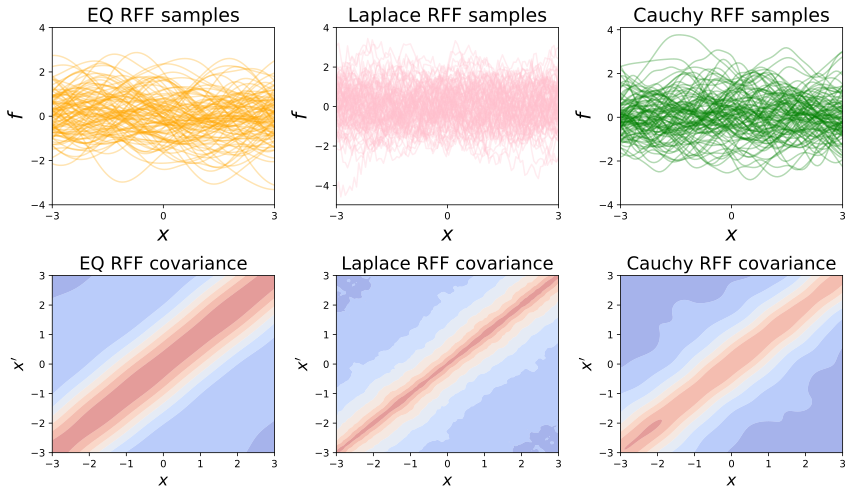

In [383]:
# Titles for sample plots
sample_titles = ['EQ RFF samples',
                 'Laplace RFF samples',
                 'Cauchy RFF samples']

# Titles for kernel plots
kernel_titles = ['EQ RFF covariance',
                 'Laplace RFF covariance',
                 'Cauchy RFF covariance']

colors = ['orange', 'pink', 'green']

# Plot samples and linear model covariances
plt.figure(figsize=(12,7))

for i in range(3):

    functions, features = samples[i]

    plt.subplot(2, 3, i + 1)

    plt.plot(x, functions.T, color=colors[i], alpha=0.3)
    plt.xlim([x.min(), x.max()])
    plt.xlabel("$x$", fontsize=20)
    plt.ylabel("$f$", fontsize=20)
    plt.xticks(np.linspace(-3, 3, 3))
    plt.yticks(np.linspace(-4, 4, 5))
    plt.title(sample_titles[i], fontsize=19)

    plt.subplot(2, 3, i + 4)

    cov = np.einsum('ij, ik -> jk', features[0], features[0])

    x1, x2 = np.meshgrid(x, x)

    plt.contourf(x1, x2, cov, cmap="coolwarm", alpha=0.5)
    plt.xlabel("$x$", fontsize=16)
    plt.ylabel("$x'$", fontsize=16)
    plt.title(kernel_titles[i], fontsize=18)
    
plt.tight_layout()
plt.show()

### Approximate GP regression

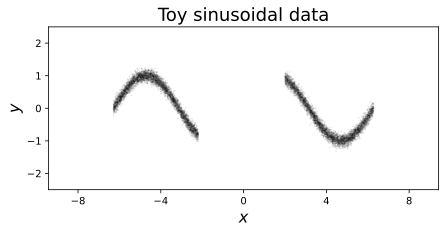

In [373]:
# Number of datapoints to generate
num_data = 5000

# Generate sinusoidal data with a gap in input space
x_data = 4 * np.pi * (np.random.uniform(size=(3 * num_data, 1)) - 0.5)
x_data = np.sort(x_data, axis=0)
x_data = np.concatenate([x_data[:(x_data.shape[0]//3)],
                         x_data[-(x_data.shape[0]//3):]],
                        axis=0)
y_data = np.sin(x_data) + 1e-1 * np.random.normal(size=x_data.shape)
        
# Plot data
plt.figure(figsize=(7, 3))
    
# Plot data points
plt.scatter(x_data, y_data, marker='+', color='k', s=1, alpha=0.1)

# Format plot
plt.title('Toy sinusoidal data', fontsize=18)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16)
plt.xticks(np.linspace(-8, 8, 5))
plt.yticks(np.linspace(-2, 2, 5))
plt.xlim([1.5 * x_data.min(), 1.5 * x_data.max()])
plt.ylim([-2.5, 2.5])
plt.show()

In [374]:
def rff_gp_posterior(x_data, y_data, x_pred, kernel, lengthscale, coefficient, num_features, noise):
    
    num_data = x_data.shape[0]
    x_full = np.concatenate([x_pred, x_data])
    
    _, features = sample_rff(x=x_full, 
                             kernel=kernel, 
                             lengthscale=lengthscale, 
                             coefficient=coefficient, 
                             num_samples=1, 
                             num_features=num_features)
    features = features[0]
    
    features_pred = features[:, :-num_data]
    features_data = features[:, -num_data:]
    
    iS = np.eye(features_data.shape[0]) + features_data @ features_data.T * noise ** -2

    mean_pred = noise ** -2 * features_pred.T @ np.linalg.solve(iS, features_data @ y_data)[:, 0]
    
    var_pred = np.einsum('fn, fn -> n',
                         features_pred,
                         np.linalg.solve(iS, features_pred))
    
    return mean_pred, var_pred

In [375]:
kernels = ['eq', 'laplace', 'cauchy']

lengthscale = 1e0
coefficient = 1e0
num_features = 100

noise = 1e-1
num_pred = 100

x_pred = np.linspace(1.5 * x_data.min(),
                     1.5 * x_data.max(),
                     num_pred)[:, None]

In [376]:
np.random.seed(0)

%time posteriors = [rff_gp_posterior(x_data,       \
                                     y_data,       \
                                     x_pred,       \
                                     kernel,       \
                                     lengthscale,  \
                                     coefficient,  \
                                     num_features, \
                                     noise)        \
                    for kernel in kernels]

CPU times: user 195 ms, sys: 41.6 ms, total: 236 ms
Wall time: 80.6 ms


In [380]:
# Titles for sample plots
posterior_titles = ['EQ RFF posterior',
                    'Laplace RFF posterior',
                    'Cauchy RFF posterior']

colors = ['orange', 'pink', 'green']

plt.figure(figsize=(12, 3))

for i in range(3):

    mean_pred, var_pred = posteriors[i]

    plt.subplot(1, 3, i + 1)
    
    # Plot posterior
    plt.plot(x_pred[:, 0], mean_pred, color='k')
    plt.fill_between(x_pred[:, 0],
                     mean_pred - 2 * var_pred ** 0.5,
                     mean_pred + 2 * var_pred ** 0.5,
                     color=colors[i],
                     alpha=0.3)
    
    # Plot data
    plt.scatter(x_data, y_data, marker='+', color='k', s=1, alpha=0.1)
    
    # Format plot
    plt.title(posterior_titles[i], fontsize=18)
    plt.xlabel("$x$", fontsize=16)
    plt.ylabel("$y$", fontsize=16)
    plt.xlim([x_pred.min(), x_pred.max()])
    plt.xticks(np.linspace(-8, 8, 5))
    plt.yticks(np.linspace(-2, 2, 5))
    plt.ylim([-2.5, 2.5])
    
plt.tight_layout()
plt.show()

## Conclusion

Random Fourier Features are a cheap and efficient way to sample from a Gaussian Process (GP) prior. By using a finite number of features $M$, smaller than the number of datapoints $N$, allows us to perform approximate GP regression, reducing the computational complexity from $\mathcal{O}(N^3)$ to $\mathcal{O}(NM^2)$.

## References

```{bibliography} ./references.bib
```